# 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [146]:
rock_df_idvs = pd.read_csv('./data/feature_presence540.txt', delim_whitespace=True, header = None)
rock_df_idvs = rock_df_idvs.iloc[:480, 2:14]
rock_df_idvs.columns = ['Token Number', 'Angular Fragments', 'Rounded Fragments', 'Straight Stripes', 
                'Curved Stripes', 'Physical Layers', 'Veins', 'Oily/Shimmery Texture', 'Splotchy',
                'Single Translucent Crystal', 'Multiple Cubic Cyrstals', 'Sandy Texture']

rock_df_dv = pd.read_excel('./data/aggregateRockData.xlsx', header = None)
rock_df_dv = rock_df_dv.iloc[:480, 1].to_frame()
rock_df_dv.columns = ['Rock']


rock_df = pd.concat([rock_df_idvs, rock_df_dv], axis=1)
rock_df.head(10)

,Token Number,Angular Fragments,Rounded Fragments,Straight Stripes,Curved Stripes,Physical Layers,Veins,Oily/Shimmery Texture,Splotchy,Single Translucent Crystal,Multiple Cubic Cyrstals,Sandy Texture,Rock
0,1,0.20,0.15,0.00,0.0,0.00,0.05,0.00,0.30,0.0,0.00,0.10,1
1,2,0.65,0.15,0.00,0.0,0.05,0.00,0.00,0.10,0.0,0.05,0.05,1
2,3,0.60,0.00,0.00,0.0,0.05,0.00,0.00,0.35,0.0,0.00,0.05,1
3,4,0.10,0.85,0.00,0.0,0.05,0.00,0.00,0.10,0.0,0.00,0.10,1
4,5,0.35,0.80,0.00,0.0,0.00,0.00,0.00,0.10,0.0,0.00,0.05,1
5,6,0.40,0.25,0.00,0.0,0.00,0.00,0.05,0.25,0.0,0.00,0.05,1
6,7,0.65,0.50,0.00,0.0,0.00,0.00,0.00,0.10,0.0,0.00,0.05,1
7,8,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.20,0.0,0.00,0.20,1
8,9,0.35,0.30,0.00,0.0,0.00,0.00,0.00,0.30,0.0,0.00,0.05,1
9,10,0.30,0.20,0.00,0.0,0.00,0.00,0.00,0.15,0.0,0.00,0.10,1


In [147]:
rock_df.shape

(480, 13)

In [148]:
rock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Token Number                480 non-null    object 
 1   Angular Fragments           480 non-null    object 
 2   Rounded Fragments           480 non-null    object 
 3   Straight Stripes            480 non-null    object 
 4   Curved Stripes              480 non-null    float64
 5   Physical Layers             480 non-null    float64
 6   Veins                       480 non-null    float64
 7   Oily/Shimmery Texture       480 non-null    float64
 8   Splotchy                    480 non-null    float64
 9   Single Translucent Crystal  480 non-null    float64
 10  Multiple Cubic Cyrstals     480 non-null    float64
 11  Sandy Texture               480 non-null    float64
 12  Rock                        480 non-null    int64  
dtypes: float64(8), int64(1), object(4)


In [149]:
# Here we have several columns that contain numeric values but are currently stored as object types. 
# We need to convert these columns to numeric types

columns_to_convert = ['Token Number', 'Angular Fragments', 'Rounded Fragments', 'Straight Stripes']

for column in columns_to_convert:
    rock_df[column] = pd.to_numeric(rock_df[column])

In [150]:
rock_df.describe()

,Token Number,Angular Fragments,Rounded Fragments,Straight Stripes,Curved Stripes,Physical Layers,Veins,Oily/Shimmery Texture,Splotchy,Single Translucent Crystal,Multiple Cubic Cyrstals,Sandy Texture,Rock
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,8.500000,0.084479,0.080208,0.067729,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854,2.000000
std,4.614582,0.193996,0.197648,0.194792,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149,0.817348
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8.500000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000,2.000000
75%,12.250000,0.050000,0.050000,0.000000,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000,3.000000
max,16.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000,3.000000


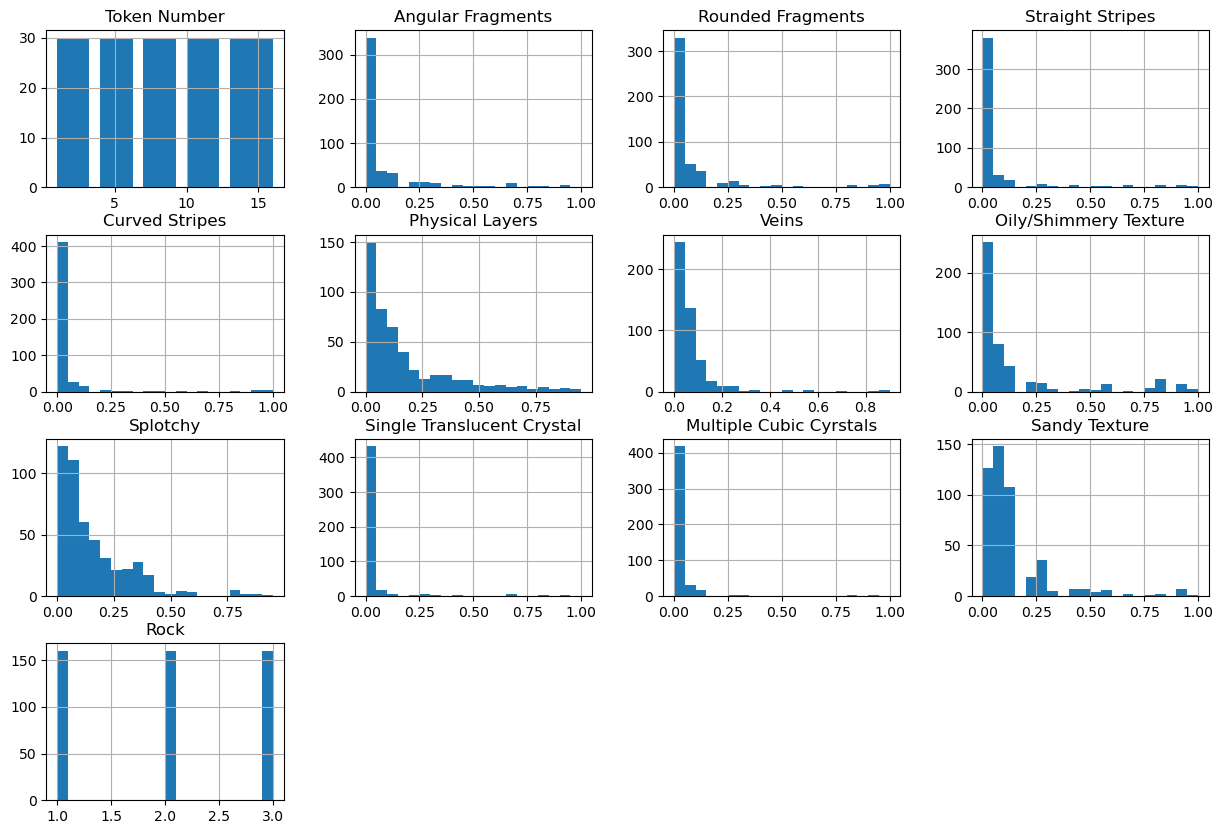

In [151]:
rock_df.hist(figsize=(15,10), bins=20)
plt.show()

## Overall Observations

- The histograms show the distribution of token numbers for different image attributes.
- Most of the histograms are right-skewed, indicating that a majority of the token numbers are concentrated on the lower end of the scale.
- Some histograms have multiple peaks, suggesting the presence of clusters or groups within the data.

## Specific Analyses

### Token Number
- The distribution of token numbers is heavily right-skewed, with most tokens having a low number.
- There is a significant drop in token numbers after 10.

### Angular Fragments
- The distribution is right-skewed, with most images having a low number of angular fragments.
- There are two peaks, one around 0.2 and another around 0.7.

### Rounded Fragments
- The distribution is right-skewed, with most images having a low number of rounded fragments.
- There is a peak around 0.25.

### Straight Stripes
- The distribution is right-skewed, with most images having a low number of straight stripes.
- There are two peaks, one around 0.2 and another around 0.7.

### Curved Stripes
- The distribution is right-skewed, with most images having a low number of curved stripes.
- There is a peak around 0.2.

### Physical Layers
- The distribution is right-skewed, with most images having a low number of physical layers.
- There is a peak around 0.2.

### Veins
- The distribution is right-skewed, with most images having a low number of veins.
- There are two peaks, one around 0.2 and another around 0.6.

### Oily/Shimmery Texture
- The distribution is right-skewed, with most images having a low number of oily/shimmery textures.
- There is a peak around 0.2.

### Splotchy
- The distribution is right-skewed, with most images having a low number of splotchy textures.
- There is a peak around 0.2.

### Single Translucent Crystal
- The distribution is right-skewed, with most images having a low number of single translucent crystals.
- There is a peak around 0.2.

### Multiple Cubic Crystals
- The distribution is right-skewed, with most images having a low number of multiple cubic crystals.
- There is a peak around 0.2.

### Sandy Texture
- The distribution is right-skewed, with most images having a low number of sandy textures.
- There is a peak around 0.2.

### Rock
- The distribution is right-skewed, with most images having a low number of rock textures.
- There is a peak around 1.5.


In [152]:
#  Missing values

rock_df.isnull().sum()

Token Number                  0
Angular Fragments             0
Rounded Fragments             0
Straight Stripes              0
Curved Stripes                0
Physical Layers               0
Veins                         0
Oily/Shimmery Texture         0
Splotchy                      0
Single Translucent Crystal    0
Multiple Cubic Cyrstals       0
Sandy Texture                 0
Rock                          0
dtype: int64

<Axes: >

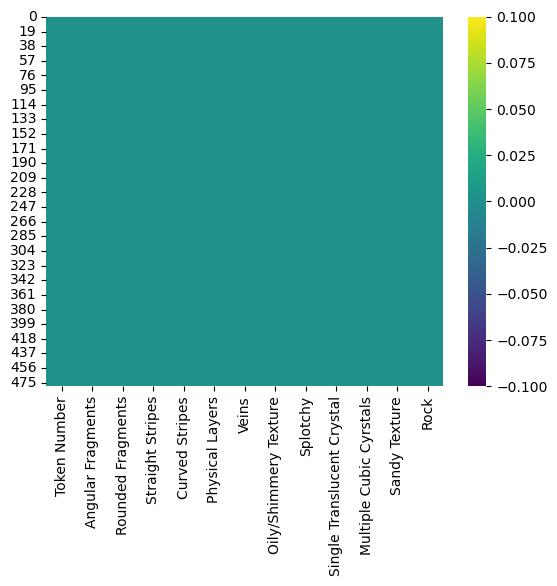

In [153]:
sns.heatmap(rock_df.isnull(), cmap='viridis')

## Null Values Assessment

There are no null values in the data.


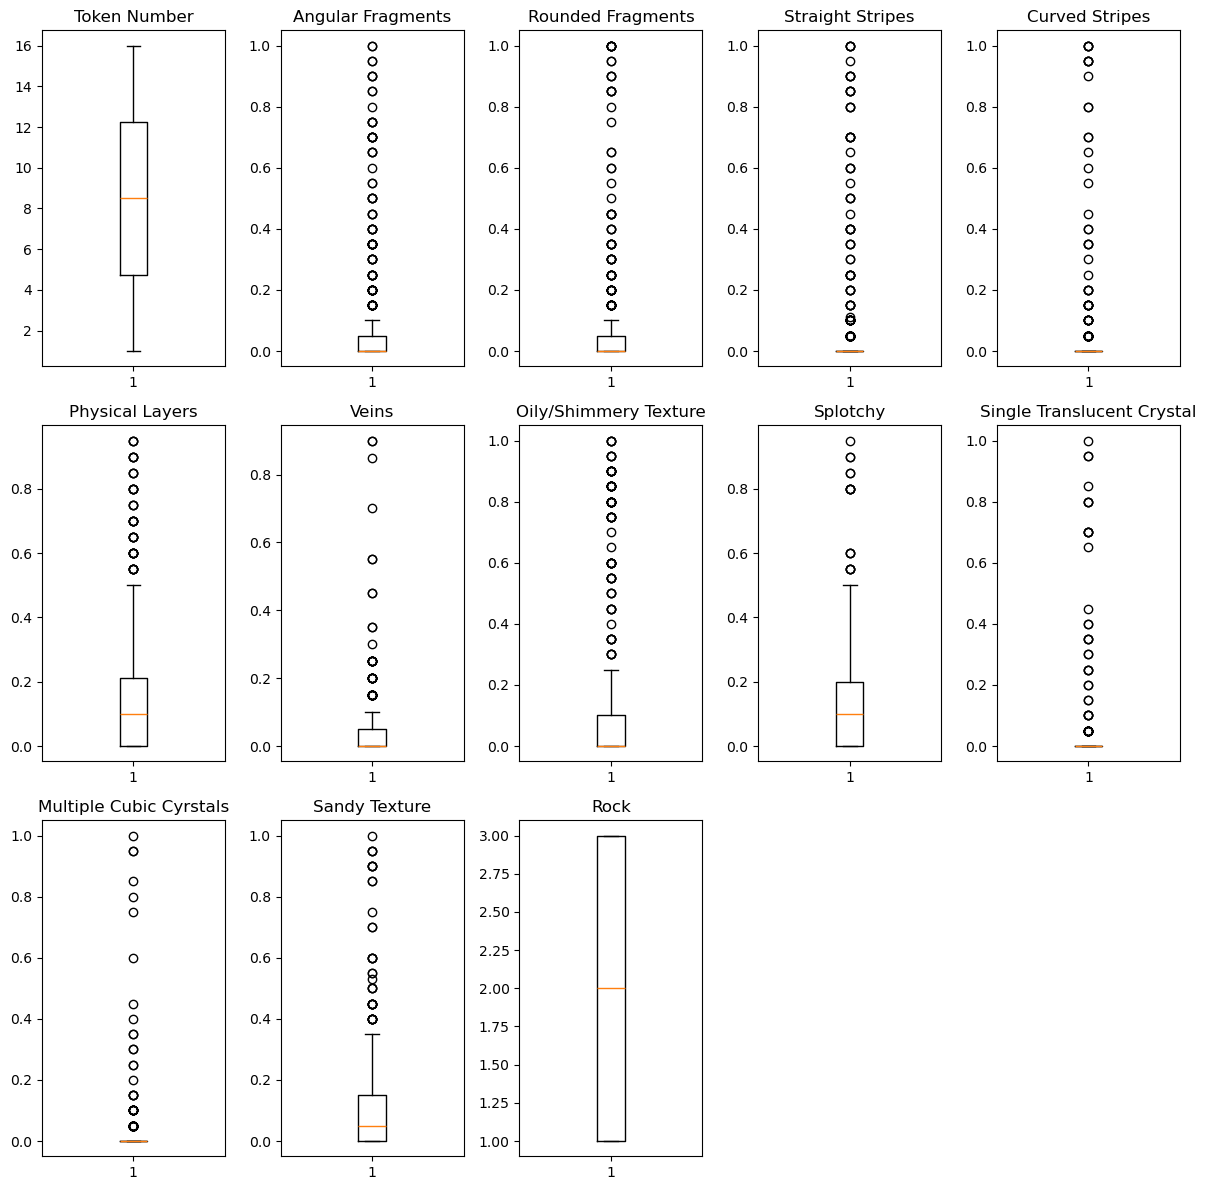

In [154]:
# Outliers

plt.figure(figsize=(12,12))

for i, column in enumerate(rock_df.columns):
    plt.subplot(3, 5, i+1)
    plt.boxplot(rock_df[column])
    plt.title(f'{column}')
    
plt.tight_layout()
plt.show()

## Outlier Assessment

After reviewing the dataset, I found that there are no outliers. The data points represent real differences in happiness across countries. Therefore, all the data is valid, and no changes are needed. This means we can use the entire dataset for analysis without removing any data points.

# 2

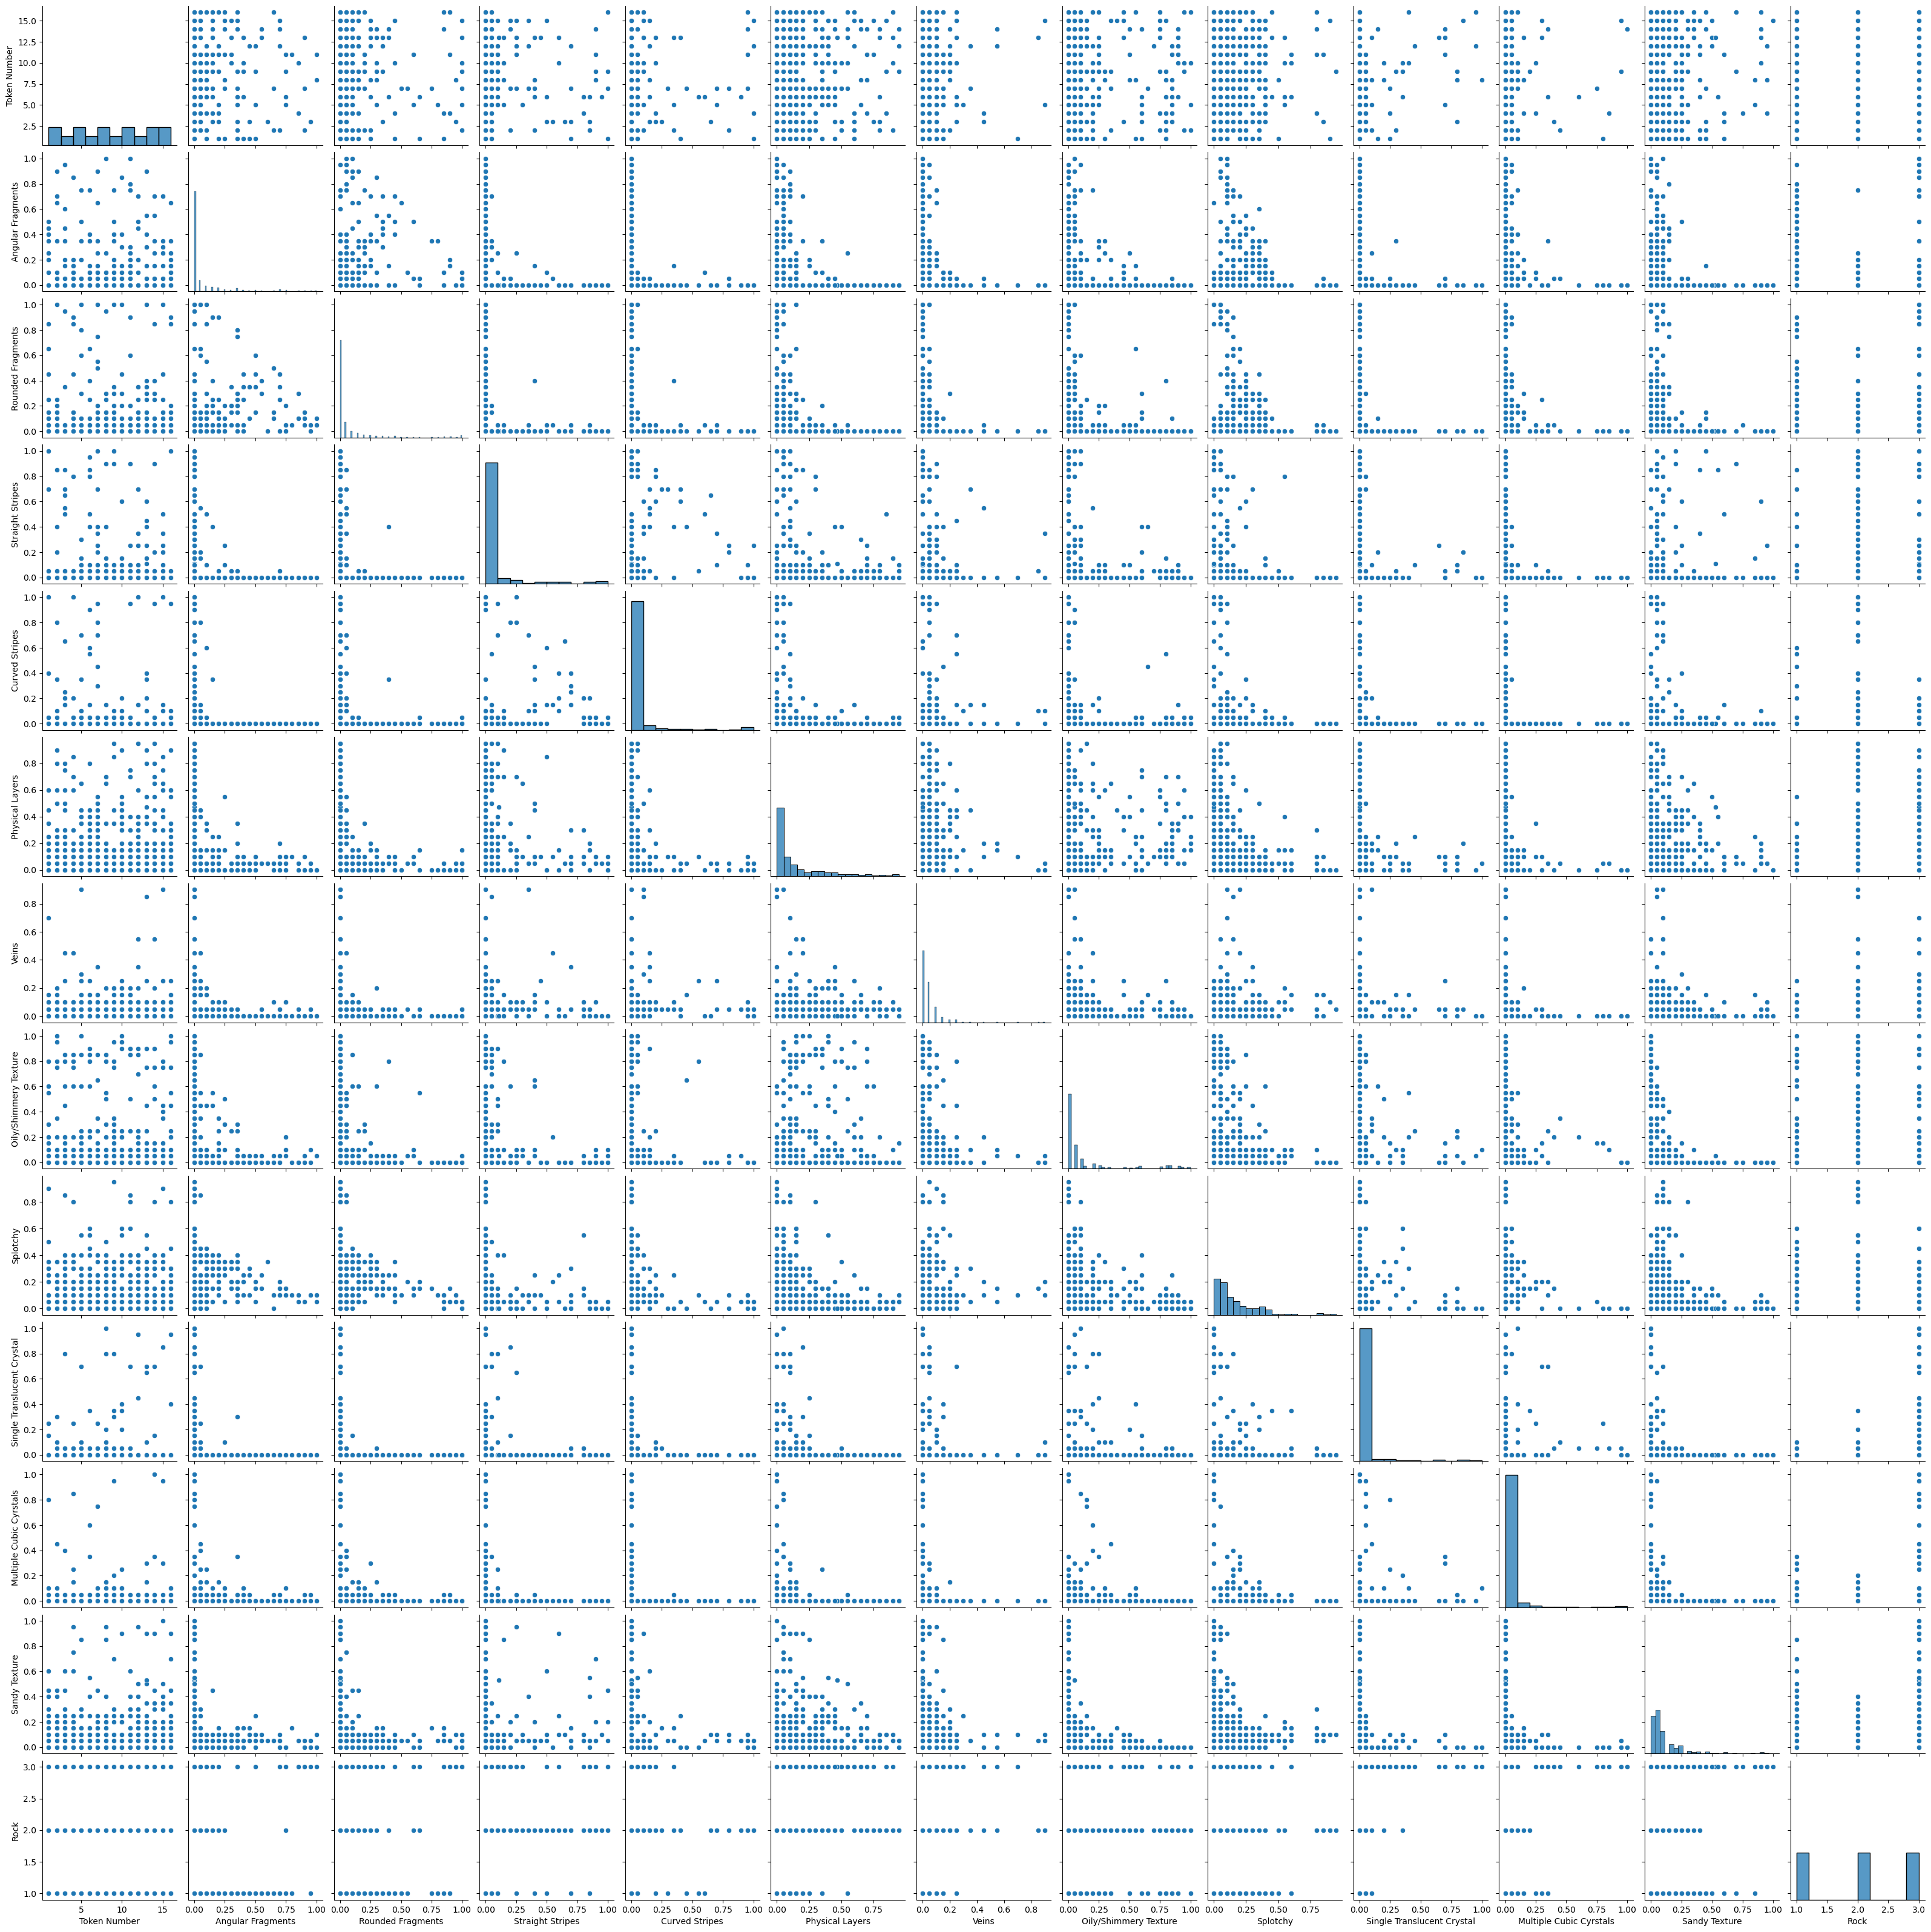

In [155]:
sns.pairplot(rock_df)
plt.show()

In [156]:
rock_df.columns

Index(['Token Number', 'Angular Fragments', 'Rounded Fragments',
       'Straight Stripes', 'Curved Stripes', 'Physical Layers', 'Veins',
       'Oily/Shimmery Texture', 'Splotchy', 'Single Translucent Crystal',
       'Multiple Cubic Cyrstals', 'Sandy Texture', 'Rock'],
      dtype='object')

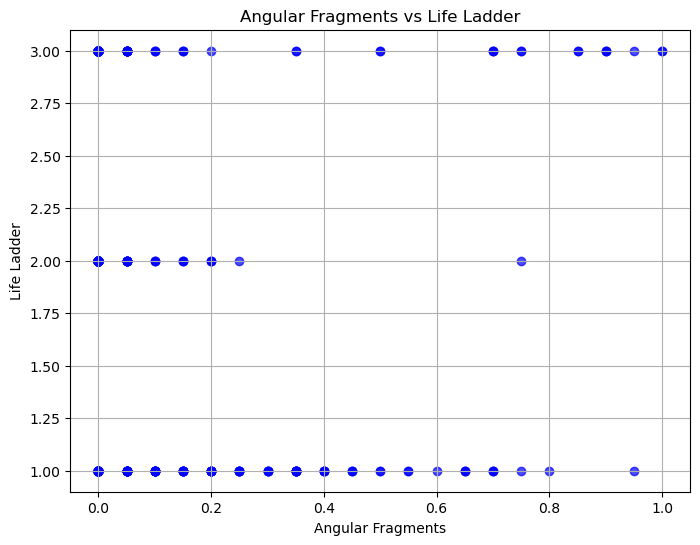

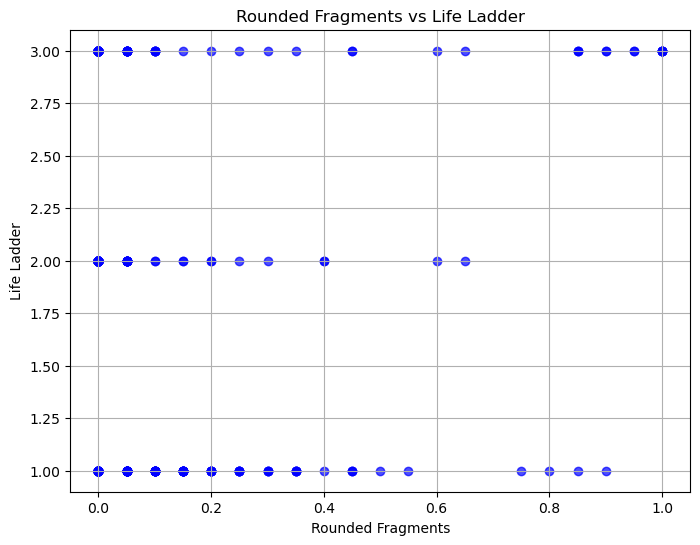

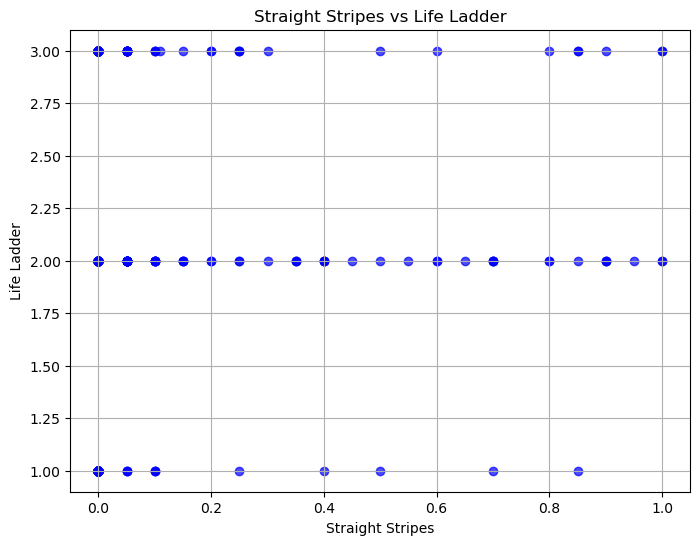

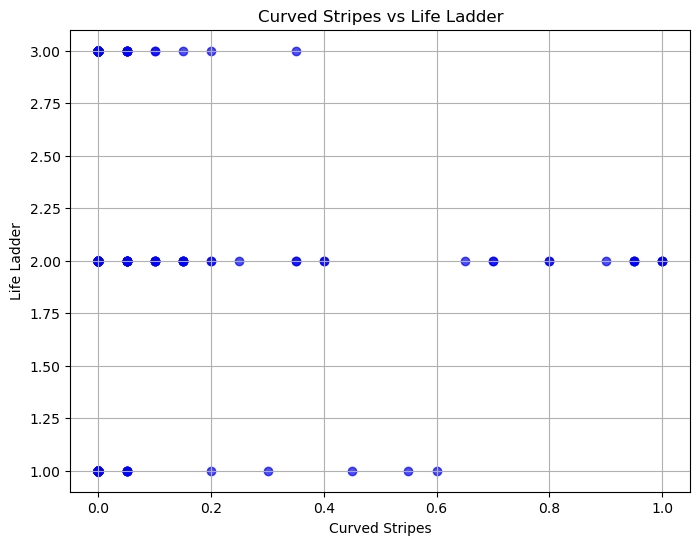

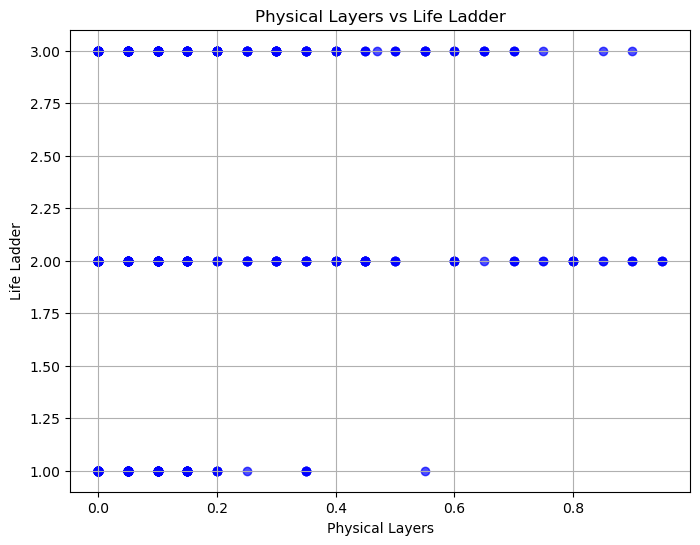

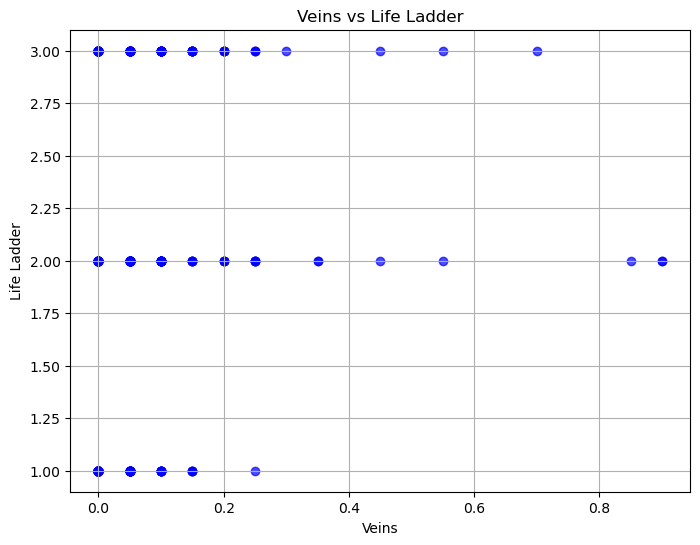

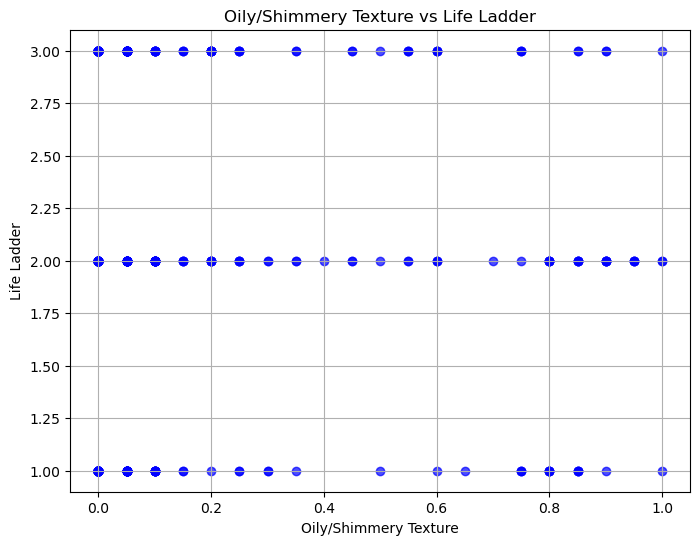

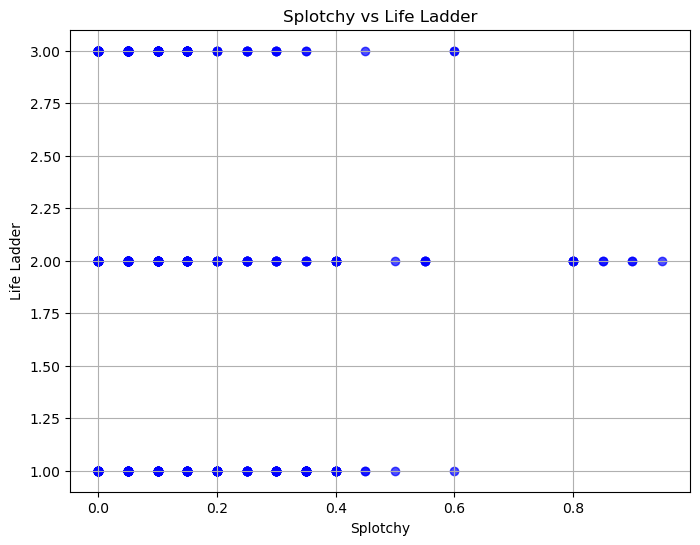

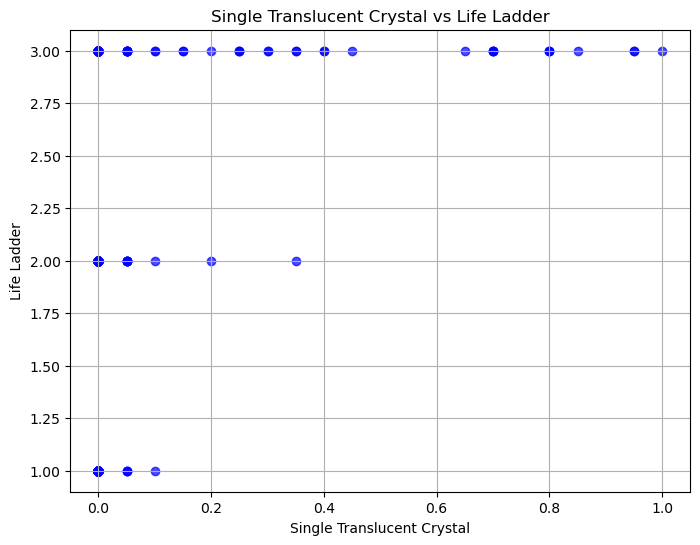

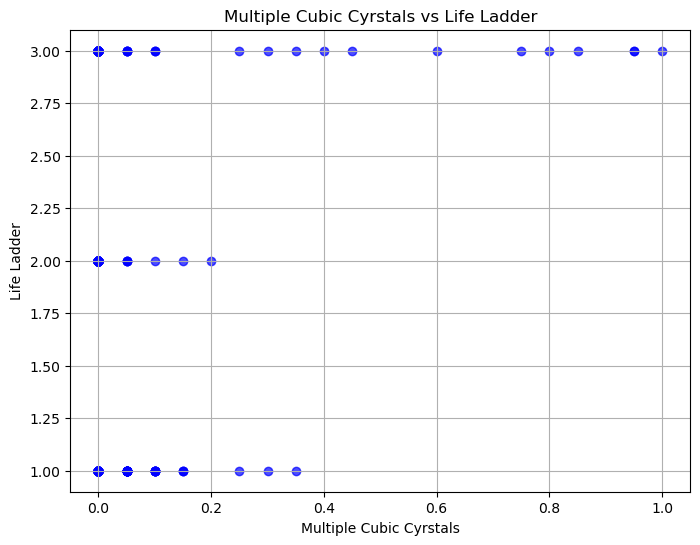

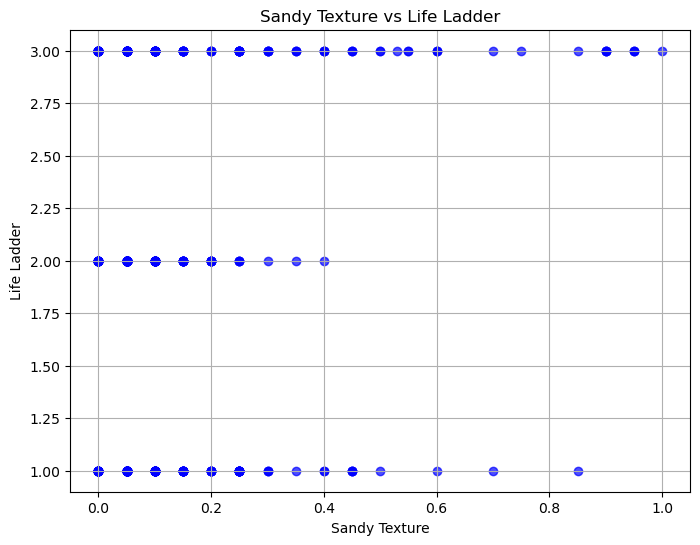

In [157]:
features = ['Angular Fragments', 'Rounded Fragments',
       'Straight Stripes', 'Curved Stripes', 'Physical Layers', 'Veins',
       'Oily/Shimmery Texture', 'Splotchy', 'Single Translucent Crystal',
       'Multiple Cubic Cyrstals', 'Sandy Texture',]
for feature in features:
    plt.figure(figsize=(8,6))
    plt.scatter(x=rock_df[feature], y=rock_df['Rock'], color= 'blue', alpha=0.7)
    plt.title(f'{feature} vs Life Ladder')
    plt.xlabel(feature)
    plt.ylabel('Life Ladder')
    plt.grid(True)
    plt.show()

In this analysis, it is evident that all features represent the various types of rocks. There are no features that distinctly differentiate one type of rock from another based on their characteristics.

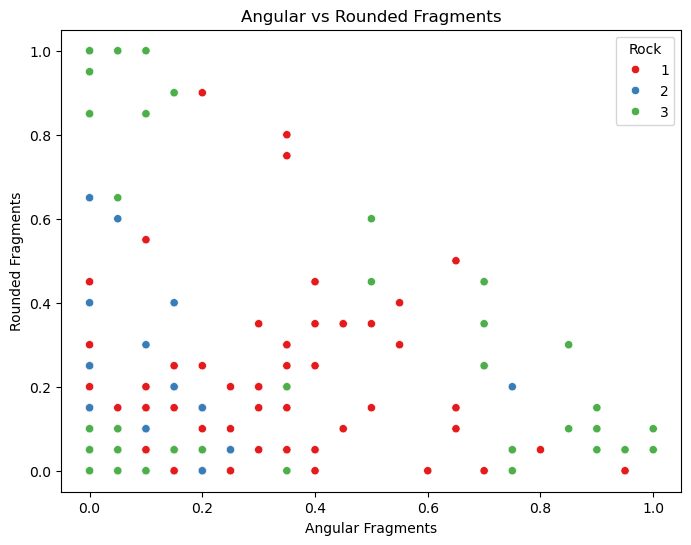

In [158]:
# Angular Fragments vs Rounded Fragements
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rock_df, x='Angular Fragments', y='Rounded Fragments', 
                hue='Rock', palette='Set1')
plt.title('Angular vs Rounded Fragments')
plt.xlabel('Angular Fragments')
plt.ylabel('Rounded Fragments')
plt.show()


Insights:

<p>Fragment Shape: The plot suggests that there's a relationship between the presence of angular and rounded fragments. Samples with high angular fragments tend to have lower rounded fragments, and vice versa.</p>
<p>Rock Type Variation: The different rock types show some variation in their fragment shapes. Some rock types might be more prone to forming angular fragments, while others might favor rounded fragments.</p>

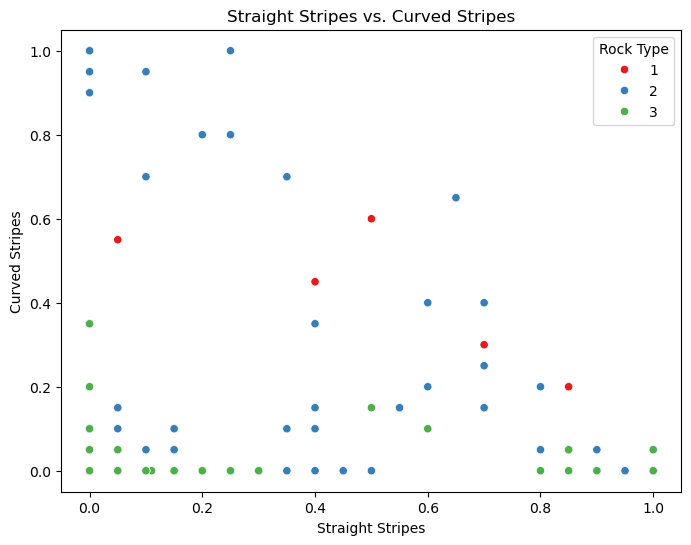

In [159]:
# Straight Stripes vs. Curved Stripes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rock_df, x='Straight Stripes', y='Curved Stripes', 
                hue='Rock', palette='Set1')
plt.title('Straight Stripes vs. Curved Stripes')
plt.xlabel('Straight Stripes')
plt.ylabel('Curved Stripes')
plt.legend(title='Rock Type')
plt.show()

Insights:

</p>Stripe Shape: The plot suggests that there's an inverse relationship between the presence of straight and curved stripes. Samples with high straight stripes tend to have lower curved stripes, and vice versa.</p>

<p>Rock Type Variation: The different rock types (1, 2, and 3) show some variation in their distribution of straight and curved stripes. Rock type 3 appears to have a higher concentration of samples with both low straight and curved stripes compared to other rock types.</p>

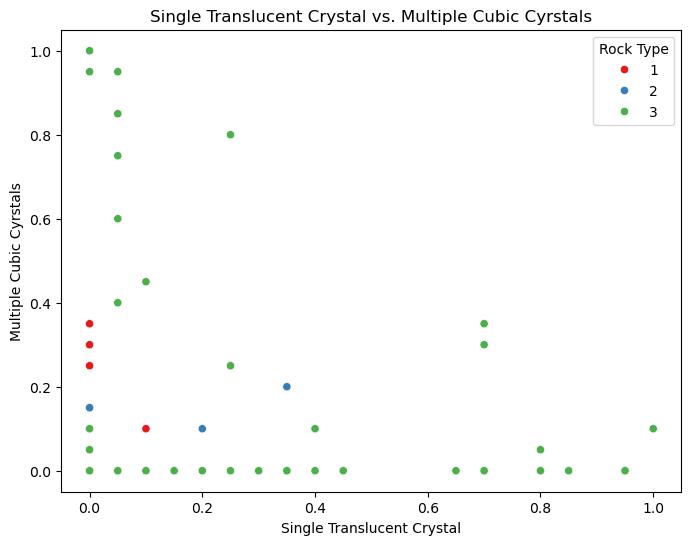

In [160]:
# Straight Stripes vs. Curved Stripes
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rock_df, x='Single Translucent Crystal', y='Multiple Cubic Cyrstals', 
                hue='Rock', palette='Set1')
plt.title('Single Translucent Crystal vs. Multiple Cubic Cyrstals')
plt.xlabel('Single Translucent Crystal')
plt.ylabel('Multiple Cubic Cyrstals')
plt.legend(title='Rock Type')
plt.show()

Insights:

<p>Crystal Type: The plot suggests that there's an inverse relationship between the presence of single translucent crystals and multiple cubic crystals. Samples with high single translucent crystals tend to have lower multiple cubic crystals, and vice versa.</p>

<p>Rock Type Variation: The different rock types (1, 2, and 3) show some variation in their distribution of single translucent crystals and multiple cubic crystals. Rock type 3 appears to have a higher concentration of samples with both low single translucent crystals and multiple cubic crystals compared to other rock types.</p>

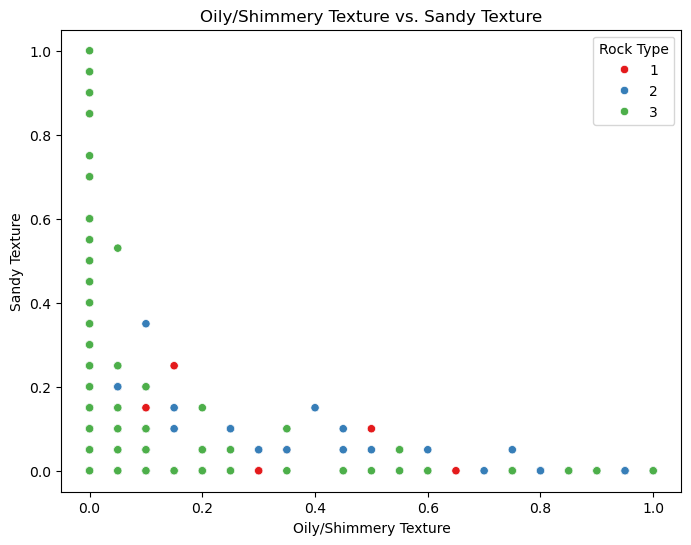

In [161]:
# Oily/Shimmery Texture vs. Sandy Texture
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rock_df, x='Oily/Shimmery Texture', y='Sandy Texture', 
                hue='Rock', palette='Set1')
plt.title('Oily/Shimmery Texture vs. Sandy Texture')
plt.xlabel('Oily/Shimmery Texture')
plt.ylabel('Sandy Texture')
plt.legend(title='Rock Type')
plt.show()

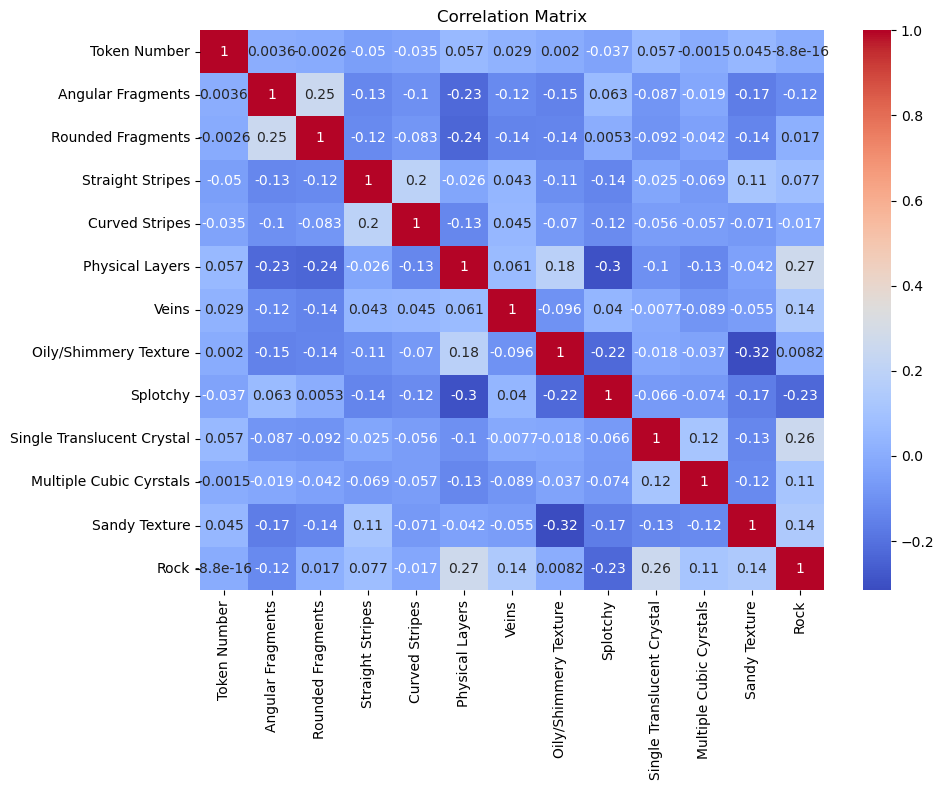

In [162]:
# Correlation between features

correlation_matrix = rock_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Analysis of the Correlation Matrix

The correlation matrix provides useful insights into the relationships between various features and the target variable "Rock."

### Overall Relationships
- Most features don’t have strong correlations with each other, indicating they capture different aspects of the rocks.
- The correlations with the target variable "Rock" are generally low, meaning no single feature alone is a strong predictor of rock type. This suggests that a combination of features may yield better results.

### Important Features
- **Physical Layers** and **Single Translucent Crystal** show the strongest positive correlations with "Rock," indicating they might be more relevant in distinguishing rock types.
- **Veins** and **Sandy Texture** also show a slight connection to "Rock," though the correlation is weaker.

### Feature Pairings
- **Angular Fragments** and **Rounded Fragments** have a slight positive relationship, suggesting that rocks with more of one type of fragment may also have a bit more of the other.
- **Splotchy** and **Physical Layers** have a slight negative relationship, implying that rocks high in one of these features tend to be lower in the other.

### Key Takeaways
- Since no feature alone is highly predictive, we may get the best results by using multiple features together.
- Focusing on **Physical Layers** and **Single Translucent Crystal** could be beneficial as they show the strongest link to the target variable "Rock."

# 3

## Feature Scaling

All independent features have values between 0 and 1. Therefore, there is no need for additional scaling.


In [163]:
# Splitting the data into train, test and validation based on token number.

X = rock_df.drop(columns=['Rock'])  
y = rock_df[['Rock', 'Token Number']]               

# Split the data based on Token Number
X_train = X[X['Token Number'].between(1, 10)].drop(columns=['Token Number'])
y_train = y[y['Token Number'].between(1, 10)].drop(columns=['Token Number'])

X_val = X[X['Token Number'].between(11, 13)].drop(columns=['Token Number'])
y_val = y[y['Token Number'].between(11, 13)].drop(columns=['Token Number'])

X_test = X[X['Token Number'].between(14, 16)].drop(columns=['Token Number'])
y_test = y[y['Token Number'].between(14, 16)].drop(columns=['Token Number'])

# Display the shapes of each set to verify the split
print("Training Data Shape (X):", X_train.shape, "y:", y_train.shape)
print("Validation Data Shape (X):", X_val.shape, "y:", y_val.shape)
print("Testing Data Shape (X):", X_test.shape, "y:", y_test.shape)


Training Data Shape (X): (300, 11) y: (300, 1)
Validation Data Shape (X): (90, 11) y: (90, 1)
Testing Data Shape (X): (90, 11) y: (90, 1)


# 4

In [164]:
# A. Multinomial Logistic Regression (Softmax Regression)

param_grid = {
    'C': [0.1, 1, 10, 100],                # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'saga'], # Solver for optimization
    'max_iter': [100, 200, 500]             # Maximum number of iterations
}

# Initialize the logistic regression model for multinomial classification
logistic_model = LogisticRegression(multi_class='multinomial')

# Set up GridSearchCV
grid_search = GridSearchCV(logistic_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Hyperparameters: {'C': 100, 'max_iter': 100, 'solver': 'newton-cg'}


## Hyperparameter Impacts

1. **Regularization Strength (`C`)**:
   - **Impact**: Controls the degree of regularization. A larger `C` (e.g., 100) reduces regularization, allowing the model to fit the training data more closely, which can be beneficial when the training data is clean and sufficient.
   - **Best Value**: `C = 100` suggests the model can learn without significant overfitting.

2. **Solver**:
   - **Impact**: Determines the optimization algorithm used. The `newton-cg` solver is effective for multi-class problems and can converge quickly on smaller datasets.
   - **Best Choice**: Using `newton-cg` indicates it was suitable for your dataset.

3. **Maximum Number of Iterations (`max_iter`)**:
   - **Impact**: Sets the limit for iterations during optimization. A value of 100 implies the model converged quickly, which is adequate for your problem.
   - **Best Value**: `max_iter = 100` indicates that convergence was achieved efficiently.

## Summary
The selected hyperparameters—high regularization (`C = 100`), `newton-cg` solver, and sufficient iterations—helped the model fit well to the training data while ensuring effective optimization.

In [165]:
# Define a function to calculate and display metrics
def evaluate_model(model, X, y, dataset_name="Dataset"):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted')
    recall = recall_score(y, predictions, average='weighted')
    f1 = f1_score(y, predictions, average='weighted')
    print(f"{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y, predictions))

In [166]:
best_model_soft_max = grid_search.best_estimator_

# Evaluate on training data
evaluate_model(best_model_soft_max, X_train, y_train, "Training Data")

Training Data Performance:
Accuracy: 0.6700
Precision: 0.6710
Recall: 0.6700
F1 Score: 0.6703

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.69      0.70       100
           2       0.63      0.66      0.64       100
           3       0.68      0.66      0.67       100

    accuracy                           0.67       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.67      0.67      0.67       300



In [167]:
# Evaluate on validation data
evaluate_model(best_model_soft_max, X_val, y_val, "Validation Data")

Validation Data Performance:
Accuracy: 0.7556
Precision: 0.7622
Recall: 0.7556
F1 Score: 0.7511

Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.90      0.83        30
           2       0.70      0.77      0.73        30
           3       0.82      0.60      0.69        30

    accuracy                           0.76        90
   macro avg       0.76      0.76      0.75        90
weighted avg       0.76      0.76      0.75        90



In [168]:
# Evaluate on test data
evaluate_model(best_model_soft_max, X_test, y_test, "Test Data")

Test Data Performance:
Accuracy: 0.6778
Precision: 0.6845
Recall: 0.6778
F1 Score: 0.6779

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.60      0.64        30
           2       0.75      0.70      0.72        30
           3       0.61      0.73      0.67        30

    accuracy                           0.68        90
   macro avg       0.68      0.68      0.68        90
weighted avg       0.68      0.68      0.68        90



In [169]:
# B. Support Vector Machine

param_grid = {
    'C': [0.1, 1, 10, 100],                      
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'degree': [2, 3, 4],                        
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  
}

# Initialize the SVM model
svm_model = SVC(probability=True)

# Set up GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_svm.fit(X_train, y_train.values.ravel())  # Ensure y is 1D

# Best hyperparameters
print("Best Hyperparameters:", grid_search_svm.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Best Hyperparameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


## Hyperparameter Impacts

1. **Regularization Parameter (`C`)**:
   - **Impact**: Controls the trade-off between margin maximization and misclassification penalties. A larger `C` (e.g., 100) leads to a more complex model that fits the training data closely.
   - **Best Value**: `C = 100` suggests effective handling of noise without excessive overfitting.

2. **Kernel Function**:
   - **Impact**: Defines the transformation of input space for classification. 
   - **Best Choice**: `rbf` kernel indicates the data likely has non-linear relationships, making it suitable for complex decision boundaries.

3. **Degree (for Polynomial Kernel)**:
   - **Impact**: Determines the complexity of the polynomial function. 
   - **Best Value**: `degree = 2` suggests a quadratic boundary is effective without overfitting.

4. **Gamma**:
   - **Impact**: Controls the influence of individual training examples. 
   - **Best Choice**: `gamma = 'scale'` provides a balanced influence across the dataset.

## Summary
The selected hyperparameters (`C = 100`, `kernel = 'rbf'`, `degree = 2`, `gamma = 'scale'`) help achieve a model that captures non-linear patterns effectively while managing complexity and generalization.


In [170]:
best_model_svm = grid_search_svm.best_estimator_

# Evaluate on training data
evaluate_model(best_model_svm, X_train, y_train, "Training Data")

Training Data Performance:
Accuracy: 0.9100
Precision: 0.9142
Recall: 0.9100
F1 Score: 0.9095

Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.99      0.93       100
           2       0.91      0.89      0.90       100
           3       0.97      0.85      0.90       100

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



In [171]:
# Evaluate on validation data
evaluate_model(best_model_svm, X_val, y_val, "Validation Data")

Validation Data Performance:
Accuracy: 0.7111
Precision: 0.7080
Recall: 0.7111
F1 Score: 0.7046

Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.90      0.81        30
           2       0.68      0.57      0.62        30
           3       0.71      0.67      0.69        30

    accuracy                           0.71        90
   macro avg       0.71      0.71      0.70        90
weighted avg       0.71      0.71      0.70        90



In [172]:
# Evaluate on test data
evaluate_model(best_model_svm, X_test, y_test, "Test Data")

Test Data Performance:
Accuracy: 0.6889
Precision: 0.6899
Recall: 0.6889
F1 Score: 0.6878

Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.77      0.72        30
           2       0.69      0.67      0.68        30
           3       0.70      0.63      0.67        30

    accuracy                           0.69        90
   macro avg       0.69      0.69      0.69        90
weighted avg       0.69      0.69      0.69        90



In [173]:
# C. Random Forest Classifier

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train.values.ravel())  # Ensure y is 1D

# Best hyperparameters
print("Best Hyperparameters:", grid_search_rf.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


## Hyperparameter Impacts

1. **Number of Trees (`n_estimators`)**: 
   - **Best Value**: `100`
   - **Impact**: Balances performance and computational efficiency by reducing overfitting.

2. **Maximum Depth of Trees (`max_depth`)**: 
   - **Best Choice**: `None`
   - **Impact**: Allows trees to grow fully, capturing complex patterns in the data.

3. **Minimum Samples to Split (`min_samples_split`)**: 
   - **Best Value**: `10`
   - **Impact**: Prevents unnecessary splits, helping to control overfitting.

4. **Minimum Samples at Leaf Nodes (`min_samples_leaf`)**: 
   - **Best Value**: `1`
   - **Impact**: Enables detailed modeling, though it may risk overfitting if too complex.

## Summary
The selected hyperparameters effectively enhance model generalization while capturing the data's underlying structure.


In [174]:
best_model_rf = grid_search_rf.best_estimator_

# Evaluate on training data
evaluate_model(best_model_rf, X_train, y_train, "Training Data")

Training Data Performance:
Accuracy: 0.9167
Precision: 0.9173
Recall: 0.9167
F1 Score: 0.9168

Classification Report:
               precision    recall  f1-score   support

           1       0.94      0.92      0.93       100
           2       0.88      0.92      0.90       100
           3       0.93      0.91      0.92       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



In [175]:
# Evaluate on validation data
evaluate_model(best_model_rf, X_val, y_val, "Validation Data")

Validation Data Performance:
Accuracy: 0.7889
Precision: 0.7866
Recall: 0.7889
F1 Score: 0.7859

Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.93      0.88        30
           2       0.78      0.70      0.74        30
           3       0.76      0.73      0.75        30

    accuracy                           0.79        90
   macro avg       0.79      0.79      0.79        90
weighted avg       0.79      0.79      0.79        90



In [176]:
# Evaluate on test data
evaluate_model(best_model_rf, X_test, y_test, "Test Data")

Test Data Performance:
Accuracy: 0.6444
Precision: 0.6432
Recall: 0.6444
F1 Score: 0.6435

Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.70      0.69        30
           2       0.65      0.67      0.66        30
           3       0.61      0.57      0.59        30

    accuracy                           0.64        90
   macro avg       0.64      0.64      0.64        90
weighted avg       0.64      0.64      0.64        90



# 5

In [177]:
# Create a Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('logistic', best_model_soft_max),
    ('svm', best_model_svm),
    ('random_forest', best_model_rf)],
    voting='soft'  # Use soft voting to consider predicted probabilities
)

# Fit the ensemble model on the training data
voting_clf.fit(X_train, y_train.values.ravel())

VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=100,
                                                 multi_class='multinomial',
                                                 solver='newton-cg')),
                             ('svm', SVC(C=100, degree=2, probability=True)),
                             ('random_forest',
                              RandomForestClassifier(min_samples_split=10,
                                                     random_state=42))],
                 voting='soft')

In [178]:
# Evaluate on training data
evaluate_model(voting_clf, X_train, y_train.values.ravel(), dataset_name="Training Set")

Training Set Performance:
Accuracy: 0.8500
Precision: 0.8521
Recall: 0.8500
F1 Score: 0.8503

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.86      0.86       100
           2       0.80      0.86      0.83       100
           3       0.89      0.83      0.86       100

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



In [179]:
# Evaluate on validation data
evaluate_model(voting_clf, X_val, y_val, "Validation Data")

Validation Data Performance:
Accuracy: 0.7556
Precision: 0.7536
Recall: 0.7556
F1 Score: 0.7515

Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.93      0.88        30
           2       0.68      0.70      0.69        30
           3       0.76      0.63      0.69        30

    accuracy                           0.76        90
   macro avg       0.75      0.76      0.75        90
weighted avg       0.75      0.76      0.75        90



In [180]:
# Evaluate on test data
evaluate_model(voting_clf, X_test, y_test, "Test Data")

Test Data Performance:
Accuracy: 0.7111
Precision: 0.7116
Recall: 0.7111
F1 Score: 0.7112

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.70      0.71        30
           2       0.73      0.73      0.73        30
           3       0.68      0.70      0.69        30

    accuracy                           0.71        90
   macro avg       0.71      0.71      0.71        90
weighted avg       0.71      0.71      0.71        90



## Classifier Performance Comparison

| Metric                | Softmax Regression | Support Vector Machine | Random Forest     | Ensemble Soft Voting |
|-----------------------|--------------------|------------------------|--------------------|----------------------|
| **Training Accuracy** | 67.00%             | 91.00%                 | 91.67%             | 84.67%               |
| **Validation Accuracy**| 75.56%            | 71.11%                 | 78.89%             | 75.56%               |
| **Test Accuracy**     | 67.78%             | 68.89%                 | 64.44%             | 71.11%               |
| **Training Precision** | 67.10%            | 91.42%                 | 91.73%             | 84.92%               |
| **Validation Precision**| 76.22%           | 70.80%                 | 78.66%             | 75.36%               |
| **Test Precision**    | 68.45%             | 68.99%                 | 64.32%             | 71.32%               |
| **Training Recall**   | 67.00%             | 91.00%                 | 91.67%             | 84.67%               |
| **Validation Recall** | 75.56%             | 71.11%                 | 78.89%             | 75.56%               |
| **Test Recall**       | 67.78%             | 68.89%                 | 64.44%             | 71.11%               |
| **Training F1 Score** | 67.03%             | 90.95%                 | 91.68%             | 84.70%               |
| **Validation F1 Score**| 75.11%            | 70.46%                 | 78.59%             | 75.15%               |
| **Test F1 Score**     | 67.79%             | 68.78%                 | 64.35%             | 71.16%               |

## Analysis

1. **Training Performance**:
   - The **Random Forest** classifier has the highest training accuracy (91.67%) and F1 score (91.68%), indicating it effectively fits the training data.
   - The **Support Vector Machine** follows closely, while the **Ensemble Soft Voting Classifier** shows a moderate performance at 84.67%.

2. **Validation Performance**:
   - The **Random Forest** maintains the highest validation accuracy (78.89%), followed closely by **Softmax Regression** and the **Ensemble Soft Voting Classifier**, both at 75.56%.
   - The **Support Vector Machine** has the lowest validation performance.

3. **Test Performance**:
   - The **Ensemble Soft Voting Classifier** achieves the highest accuracy (71.11%) and precision (71.32%) on the test set, indicating good generalization from training to unseen data.
   - The **Support Vector Machine** and **Softmax Regression** have similar test accuracies, while **Random Forest** shows the lowest performance.

4. **Class-Specific Performance**:
   - The **Ensemble Soft Voting Classifier** exhibits balanced performance across classes in the test data, particularly for classes 1 and 2.
   - The **Random Forest** performs well on training data but struggles more with test data.

## Conclusion
- The **Random Forest** classifier leads in training and validation metrics but struggles on the test data.
- The **Ensemble Soft Voting Classifier** shows strong test performance, suggesting it benefits from the combination of multiple classifiers.
- The **Support Vector Machine** has the lowest validation performance, indicating it may not generalize as well as the other models.

Overall, this comparison emphasizes the importance of using ensemble methods, as they can provide better generalization capabilities, especially evident in the test performance of the **Ensemble Soft Voting Classifier**. The Ensemble Soft Voting Classifier appears to be the best choice based on the provided metrics.

# 6

In [181]:
human_df = pd.read_csv('./data/trialData.csv')
human_df = human_df[(human_df['rocknumber']>=1) & (human_df['rocknumber']<=480)]
human_df.head()

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN


In [182]:
train_human_df = human_df[human_df['block'].isin([1, 2, 3])]
test_human_df = human_df[human_df['block'] == 4]

In [183]:
train_accuracy = train_human_df['cat_correct'].mean()
test_accuracy = test_human_df['cat_correct'].mean()

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.5599349490660221
Test Accuracy: 0.5984143924378716


## Comparison of Human Accuracy and Model Accuracy

## Training Set
- **Human Training Accuracy**: 55.99%
- **Model Training Accuracy**: 85.67%

The model significantly outperforms human accuracy on the training set by over 29 percentage points. This indicates that the model has learned to identify patterns in the training data more effectively and consistently than humans, likely due to its systematic approach in applying learned patterns.

## Test Set
- **Human Test Accuracy**: 59.84%
- **Model Test Accuracy**: 70.00%

On the test set, the model also outperforms human accuracy, though the gap is smaller (around 10 percentage points). The drop in model accuracy from training to test (85.67% to 70.00%) shows that the model may experience some challenges in generalization, similar to humans, but it still maintains a notable advantage in predictive accuracy over human performance.

## Summary
Overall, the model demonstrates higher accuracy across both training and test sets compared to human performance, showcasing its effectiveness in identifying patterns with greater accuracy. The model's ability to consistently outperform human predictions, especially on unseen test data, underscores its robustness and precision for this task.


In [184]:
human_rock_stats = human_df.groupby('rocknumber')['cat_correct'].agg(['mean', 'std']).reset_index()
human_rock_stats.columns = ['rocknumber', 'average_accuracy', 'accuracy_std_dev']
print(human_rock_stats)

     rocknumber  average_accuracy  accuracy_std_dev
0             1          0.746951          0.435423
1             2          0.719512          0.452002
2             3          0.451220          0.500677
3             4          0.500000          0.503077
4             5          0.512195          0.502927
..          ...               ...               ...
475         476          0.576220          0.494911
476         477          0.524390          0.502478
477         478          0.426829          0.497661
478         479          0.365854          0.484633
479         480          0.414634          0.495691

[480 rows x 3 columns]


In [185]:
model_probabilities_df = pd.DataFrame(voting_clf.predict_proba(X.drop(['Token Number'], axis=1)),
                                     columns=['Igneous', 'Metamorphic','Sedimentary'])
predict_class = pd.DataFrame(voting_clf.predict(X.drop(['Token Number'], axis=1)),
                             columns=['Rock Class'])

model_probabilities_df['Voting Classifier'] = model_probabilities_df[['Igneous',
                                                                    'Metamorphic',
                                                                    'Sedimentary']].max(axis=1)

model_probabilities_df = pd.concat([model_probabilities_df, predict_class], axis=1)


rock_type_mapping = {1: 'Igneous', 2: 'Metamorphic', 3: 'Sedimentary'}
model_probabilities_df['Rock Type'] = model_probabilities_df['Rock Class'].map(rock_type_mapping)


model_probabilities_df.head(10)

,Igneous,Metamorphic,Sedimentary,Voting Classifier,Rock Class,Rock Type
0,0.789838,0.158025,0.052137,0.789838,1,Igneous
1,0.688705,0.040637,0.270658,0.688705,1,Igneous
2,0.869442,0.074484,0.056074,0.869442,1,Igneous
3,0.419639,0.053674,0.526687,0.526687,3,Sedimentary
4,0.546209,0.035117,0.418673,0.546209,1,Igneous
5,0.817108,0.107493,0.075399,0.817108,1,Igneous
6,0.586615,0.042111,0.371274,0.586615,1,Igneous
7,0.689046,0.242236,0.068718,0.689046,1,Igneous
8,0.826817,0.108537,0.064646,0.826817,1,Igneous
9,0.833528,0.080180,0.086292,0.833528,1,Igneous


In [186]:
# Combining Human accuracy and Model probabilities to plot scatter plot
combined_df = pd.concat([human_rock_stats, model_probabilities_df], axis=1)
combined_df.head()

,rocknumber,average_accuracy,accuracy_std_dev,Igneous,Metamorphic,Sedimentary,Voting Classifier,Rock Class,Rock Type
0,1,0.746951,0.435423,0.789838,0.158025,0.052137,0.789838,1,Igneous
1,2,0.719512,0.452002,0.688705,0.040637,0.270658,0.688705,1,Igneous
2,3,0.451220,0.500677,0.869442,0.074484,0.056074,0.869442,1,Igneous
3,4,0.500000,0.503077,0.419639,0.053674,0.526687,0.526687,3,Sedimentary
4,5,0.512195,0.502927,0.546209,0.035117,0.418673,0.546209,1,Igneous


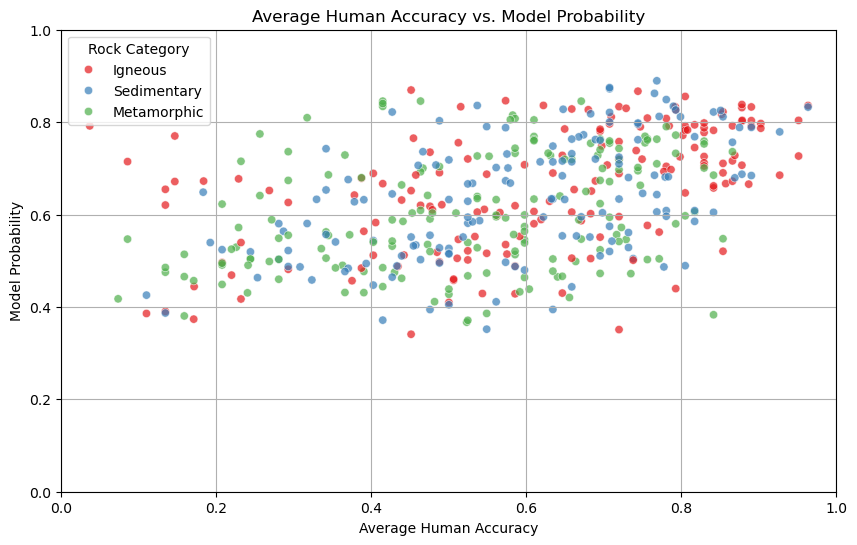

In [187]:
# Average Human Accuracy vs. Model Probability Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='average_accuracy', y='Voting Classifier', hue='Rock Type', 
                palette='Set1', alpha=0.7)
plt.title('Average Human Accuracy vs. Model Probability')
plt.xlabel('Average Human Accuracy')
plt.ylabel('Model Probability')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title='Rock Category')
plt.show()

In [188]:
corr_p_dict = {}

for rock_category in combined_df['Rock Type'].unique():
    rock_data = combined_df[combined_df['Rock Type'] == rock_category]
    corr_coef, p_value = pearsonr(rock_data['average_accuracy'], rock_data['Voting Classifier'])
    corr_p_dict[rock_category] = {'correlation_coefficient':corr_coef,
                                  'p_value':p_value}
    
all_rocks_coeff, all_rocks_p_value = pearsonr(combined_df['average_accuracy'], combined_df['Voting Classifier'])
corr_p_dict['All Rocks'] = {'correlation_coefficient':all_rocks_coeff, 'p_value':all_rocks_p_value}

In [189]:
for category, metrics in corr_p_dict.items():
    significance = "Significant" if metrics['p_value'] < 0.05 else "Not Significant"
    print(f"Category: {category}")
    print(f"  Correlation Coefficient: {metrics['correlation_coefficient']:.4f}")
    print(f"  P-value: {metrics['p_value']:.4f} - {significance}\n")

Category: Igneous
  Correlation Coefficient: 0.4931
  P-value: 0.0000 - Significant

Category: Sedimentary
  Correlation Coefficient: 0.5189
  P-value: 0.0000 - Significant

Category: Metamorphic
  Correlation Coefficient: 0.3544
  P-value: 0.0000 - Significant

Category: All Rocks
  Correlation Coefficient: 0.4735
  P-value: 0.0000 - Significant



Yes, the correlation is significant for all categories based on the results you provided:

- **Igneous**: Significant (p-value = 0.0000)
- **Sedimentary**: Significant (p-value = 0.0000)
- **Metamorphic**: Significant (p-value = 0.0000)
- **All Rocks**: Significant (p-value = 0.0000)

Each correlation coefficient indicates a positive relationship between average human accuracy and model probabilities. The p-values of 0.0000 for each category confirm that these correlations are statistically significant. Therefore, we can confidently conclude that there is a significant correlation between human accuracy and model probabilities for each rock type and overall.
